## Probabilistic Graphical Model - Base VAE
**Author:** Felipe Cortes Jaramillo

**Description:** Basic implementation of variational auto-encoder using the data from "MLDM Project."

**References:** The following code was inspired in the tutorial: https://www.tensorflow.org/tutorials/generative/cvae

### Libraries and Data Pre-processing:

In [1]:
# First, we install libraries needed
!pip install tensorflow-probability neurite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19532 sha256=adc31a6fa16be6c768f3735fa98f146fd70ca9a7448fd63776947fba169e2bb9
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import glob
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import time

from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# We mount Colab for this
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Let's load the data (Based on a cut)
images_route_24_30 = f'./../../data/size_480/24_30/'
images_route_22_30 = f'./../../data/size_480/22_30/'
images_route_20_2  = f'./../../data/size_480/20_2/'

filelist_24_30  = sorted(glob.glob(f'{images_route_24_30}*.jpg'))
filelist_22_30 = sorted(glob.glob(f'{images_route_22_30}*.jpg'))
filelist_20_2 = sorted(glob.glob(f'{images_route_20_2}*.jpg'))

data_set_24_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_24_30])
data_set_22_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_22_30])
data_set_20_2 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_20_2])


# Print shapes
print(f"Shape of data 24_30 set: {data_set_24_30.shape}")
print(f"Shape of data 22_30 set: {data_set_22_30.shape}")
print(f"Shape of data 20_2 set: {data_set_20_2.shape}")

Shape of data 24_30 set: (50, 960, 960)
Shape of data 22_30 set: (50, 960, 960)
Shape of data 20_2 set: (50, 960, 960)


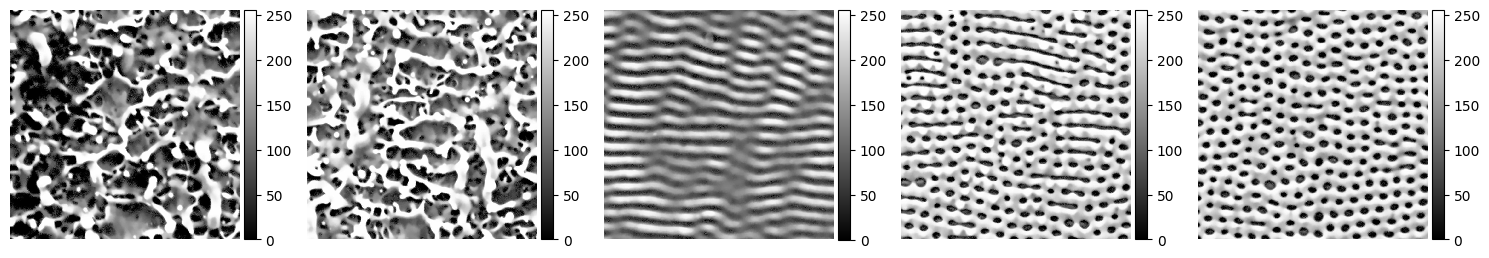

In [5]:
# We can visualize some of the data from the first set (trajectory 24_30)

nb_vis = 5
# choose nb_vis sample indexes
idx = np.random.choice(data_set_24_30.shape[0], nb_vis, replace=False)
example_digits = [f for f in data_set_24_30[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [6]:
# Basic normalization step to be in range [0 - 1]

x_24_30 = np.expand_dims(data_set_24_30.astype('float32')/255, -1)
x_22_30 = np.expand_dims(data_set_22_30.astype('float32')/255, -1)
x_20_2  = np.expand_dims(data_set_20_2.astype('float32')/255, -1)

# Verify
print('Set of 24_30 maximum value', x_24_30.max())
print('Set of 22_30 maximum value', x_22_30.max())
print('Set of 20_2 maximum value', x_20_2.max())

Set of 24_30 maximum value 1.0
Set of 22_30 maximum value 1.0
Set of 20_2 maximum value 1.0


In [7]:
# Finally, we define the train and test set for each trajectory

X_train_24_30, X_test_24_30 = train_test_split(x_24_30, test_size=0.1, random_state=42)
X_train_22_30, X_test_22_30 = train_test_split(x_22_30, test_size=0.1, random_state=42)
X_train_20_2, X_test_20_2 = train_test_split(x_20_2, test_size=0.1, random_state=42)

print('< -------- // -------- >')
print(f'Shape of 24_30 training data: {X_train_24_30.shape} and test data: {X_test_24_30.shape}')
print(f'Shape of 22_30 training data: {X_train_22_30.shape} and test data: {X_test_22_30.shape}')
print(f'Shape of 20_2 training data: {X_train_20_2.shape} and test data: {X_test_20_2.shape}')

< -------- // -------- >
Shape of 24_30 training data: (45, 960, 960, 1) and test data: (5, 960, 960, 1)
Shape of 22_30 training data: (45, 960, 960, 1) and test data: (5, 960, 960, 1)
Shape of 20_2 training data: (45, 960, 960, 1) and test data: (5, 960, 960, 1)


### Model Construction and Hyper-parameter selection:

In [8]:
# Hyper-parameters and trajectory selection:
epochs = 15
latent_dim = 48
num_examples_to_generate = 16

# Trajectory (24_30 in this case):
train_dataset = (tf.data.Dataset.from_tensor_slices(X_train_24_30)
                 .shuffle(45).batch(1))
test_dataset = (tf.data.Dataset.from_tensor_slices(X_test_24_30)
                .shuffle(5).batch(1))

In [9]:
# We define the CVAE model

class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(960, 960, 1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim + latent_dim),
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
      tf.keras.layers.Dense(units=240*240*32, activation=tf.nn.relu),
      tf.keras.layers.Reshape(target_shape=(240, 240, 32)),
      # Upsample back to the original image size
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
      ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [10]:
# We define the loss function (Maximizing ELBO) and optimizer (Adam Optimizer)

optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
    """Computes loss for VAE."""
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    # Add a check to ensure the logvar is not too extreme
    logvar = tf.clip_by_value(logvar, clip_value_min=-10, clip_value_max=10)

    # Check for NaNs in the network output
    tf.debugging.check_numerics(x_logit, 'x_logit')

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)

    # Check for NaNs in the loss components
    tf.debugging.check_numerics(logpx_z, 'logpx_z')
    tf.debugging.check_numerics(logpz, 'logpz')
    tf.debugging.check_numerics(logqz_x, 'logqz_x')

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss."""
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
# Instance creation and random vector for generation
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [12]:
# We define the method to generate images

def generate_and_save_images(model, test_sample):
  """Plots image based on a test_sample"""
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()

In [13]:
# Pick a sample of the test set for generating output images
for test_batch in test_dataset.take(1):
 test_sample = test_batch[0:num_examples_to_generate, :, :, :]

### Model Training:

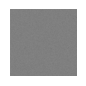

Epoch: 1, Test set ELBO: -637200.75, time elapse for current epoch: 13.642261266708374


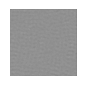

Epoch: 2, Test set ELBO: -634629.5, time elapse for current epoch: 6.4991936683654785


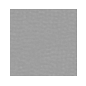

Epoch: 3, Test set ELBO: -619012.375, time elapse for current epoch: 6.602516412734985


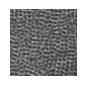

Epoch: 4, Test set ELBO: -617567.5, time elapse for current epoch: 6.521986484527588


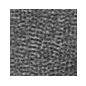

Epoch: 5, Test set ELBO: -622952.1875, time elapse for current epoch: 6.552399396896362


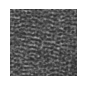

Epoch: 6, Test set ELBO: -619575.3125, time elapse for current epoch: 6.542639493942261


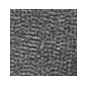

Epoch: 7, Test set ELBO: -616813.0625, time elapse for current epoch: 6.597089052200317


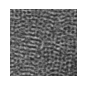

Epoch: 8, Test set ELBO: -617660.6875, time elapse for current epoch: 6.661909580230713


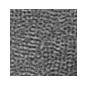

Epoch: 9, Test set ELBO: -614593.625, time elapse for current epoch: 6.63885235786438


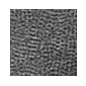

Epoch: 10, Test set ELBO: -615261.3125, time elapse for current epoch: 6.599546432495117


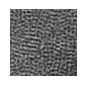

Epoch: 11, Test set ELBO: -614843.5625, time elapse for current epoch: 6.626176595687866


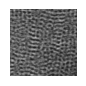

Epoch: 12, Test set ELBO: -618443.5, time elapse for current epoch: 6.6428961753845215


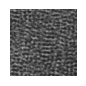

Epoch: 13, Test set ELBO: -616689.1875, time elapse for current epoch: 6.650568246841431


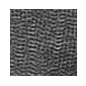

Epoch: 14, Test set ELBO: -614805.125, time elapse for current epoch: 6.684877157211304


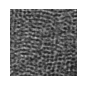

Epoch: 15, Test set ELBO: -615579.625, time elapse for current epoch: 6.682443380355835


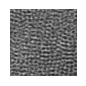

In [14]:
# Training Loop

generate_and_save_images(model, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
   loss(compute_loss(model, test_x))
  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
       .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, test_sample)

In [15]:
# End of notebook!